## Original UNET

Train on 450 samples, validate on 50 samples
Epoch 1/1000
450/450 [==============================] - 4s 9ms/sample - loss: 0.0044 - val_loss: 0.0051
Epoch 2/1000
450/450 [==============================] - 0s 229us/sample - loss: 0.0043 - val_loss: 0.0049
Epoch 3/1000
450/450 [==============================] - 0s 242us/sample - loss: 0.0041 - val_loss: 0.0047
Epoch 4/1000
450/450 [==============================] - 0s 232us/sample - loss: 0.0038 - val_loss: 0.0044
Epoch 5/1000
450/450 [==============================] - 0s 215us/sample - loss: 0.0036 - val_loss: 0.0040
Epoch 6/1000
450/450 [==============================] - 0s 219us/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/1000
450/450 [==============================] - 0s 224us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 8/1000
450/450 [==============================] - 0s 223us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 9/1000
450/450 [==============================] - 0s 225us/sample - loss: 0.0021 - val_loss: 0.0025
Epo

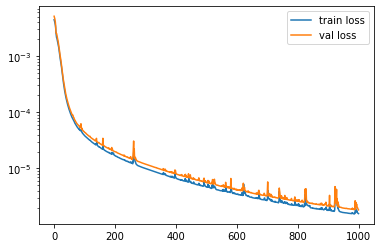

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cur_path = os.getcwd()
os.makedirs('./UNET', mode=0o777, exist_ok=True)
work_dir = os.getcwd() + '/UNET/'
os.makedirs(work_dir + 'ckpt', mode=0o777, exist_ok=True)
ckpt_dir = work_dir + 'ckpt/'

# input_img = tf.keras.Input(shape=(64, 64, 1))

class Unet(Model):
    def __init__(self, input_size, filters, activation):
        super(Unet, self).__init__()
        self.input_size = input_size
        self.filters = filters
        self.activation = activation
        self.network = self.net()
    
    def conv_block(self, x):
        x = Conv2D(filters=self.filters, kernel_size=(3, 3), activation=self.activation, padding='same')(x)
        x = Conv2D(filters=self.filters, kernel_size=(3, 3), activation=self.activation, padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')
        
    def net(self):
        inputs = Input(shape=(self.input_size, self.input_size, 1))
        
        conv1 = Conv2D(filters=self.filters//8, kernel_size=(3, 3), activation=self.activation, padding='same')(inputs)
        ## 64x64x16
        conv1 = Conv2D(filters=self.filters//8, kernel_size=(3, 3), activation=self.activation, padding='same')(conv1)
        ## 64x64x16
        pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
        ## 32x32x16
        
        conv2 = Conv2D(filters=self.filters//4, kernel_size=(3, 3), activation=self.activation, padding='same')(pool1)
        conv2 = Conv2D(filters=self.filters//4, kernel_size=(3, 3), activation=self.activation, padding='same')(conv2)
        ## 32x32x32
        pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
        ## 16x16x32
        
        conv3 = Conv2D(filters=self.filters//2, kernel_size=(3, 3), activation=self.activation, padding='same')(pool2)
        conv3 = Conv2D(filters=self.filters//2, kernel_size=(3, 3), activation=self.activation, padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
        ## 8x8x64
        
        conv4 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation=self.activation, padding='same')(pool3)
        conv4 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation=self.activation, padding='same')(conv4)
        drop4 = Dropout(rate=0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(drop4)
        ## 4x4x128
        
        conv5 = Conv2D(filters=self.filters*2, kernel_size=(3,3), activation=self.activation, padding='same')(pool4)
        conv5 = Conv2D(filters=self.filters*2, kernel_size=(3,3), activation=self.activation, padding='same')(conv5)
        drop5 = Dropout(rate=0.5)(conv5)
        ## 4x4x256
        
        up6 = Conv2D(filters=self.filters, kernel_size=(3,3), activation=self.activation, padding='same')(UpSampling2D(size=(2,2))(drop5))
        ## 8x8x128
        merge6 = Concatenate(axis=3)([drop4, up6])
        conv6 = Conv2D(filters=self.filters, kernel_size=(3,3), activation=self.activation, padding='same')(merge6)
        conv6 = Conv2D(filters=self.filters, kernel_size=(3,3), activation=self.activation, padding='same')(conv6)
        
        up7 = Conv2D(filters=self.filters//2, kernel_size=(3,3), activation=self.activation, padding='same')(UpSampling2D(size=(2,2))(conv6))
        ## 16x16x64
        merge7 = Concatenate(axis=3)([conv3, up7])
        conv7 = Conv2D(filters=self.filters//2, kernel_size=(3,3), activation=self.activation, padding='same')(merge7)
        conv7 = Conv2D(filters=self.filters//2, kernel_size=(3,3), activation=self.activation, padding='same')(conv7)

        up8 = Conv2D(filters=self.filters//4, kernel_size=(3,3), activation=self.activation, padding='same')(UpSampling2D(size=(2,2))(conv7))
        ## 32x32x32
        merge8 = Concatenate(axis=3)([conv2, up8])
        conv8 = Conv2D(filters=self.filters//4, kernel_size=(3,3), activation=self.activation, padding='same')(merge8)
        conv8 = Conv2D(filters=self.filters//4, kernel_size=(3,3), activation=self.activation, padding='same')(conv8)
        
        up9 = Conv2D(filters=self.filters//8, kernel_size=(3,3), activation=self.activation, padding='same')(UpSampling2D(size=(2,2))(conv8))
        ## 64x64x16
        merge9 = Concatenate(axis=3)([conv1, up9])
        conv9 = Conv2D(filters=self.filters//8, kernel_size=(3,3), activation=self.activation, padding='same')(merge9)
        conv9 = Conv2D(filters=self.filters//8, kernel_size=(3,3), activation=self.activation, padding='same')(conv9)
        conv9 = Conv2D(filters=2, kernel_size=(3,3), activation=self.activation, padding='same')(conv9)
        
        conv10 = Conv2D(filters=1, kernel_size=(1,1), activation=self.activation, padding='same')(conv9)
        model = Model(inputs=[inputs], outputs=[conv10])
        return model
    
    def call(self, x):
        x = self.network(x)
        return x
    

    def net_sequential(self):
        net = self.net()
        model = tf.keras.Sequential([
            net,
        ])
        return model
    
x_train = np.load(cur_path + '/data/power_maps_0_500_64.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]

P_max = x_train.max()
P_min = x_train.min()
x_train = (x_train - P_min) / (P_max - P_min)

test_idx = np.random.choice(x_train.shape[0], x_train.shape[0]//10, replace=False)
train_idx = np.setxor1d(np.arange(x_train.shape[0]), test_idx)

my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir = work_dir + '/logs'),
]

filters = 48
optimizer = Adam(lr=0.0003)
unet = Unet(64, filters, 'relu')
unet.compile(optimizer=optimizer, loss='mse')


history = unet.fit(x_train[train_idx, :,:,:], x_train[train_idx, :,:,:],
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_train[test_idx, :,:,:], x_train[test_idx, :,:,:]),
                callbacks=my_callbacks)


train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(train_loss)
ax.semilogy(val_loss)
ax.legend(['train loss', 'val loss'])
plt.savefig(work_dir + 'loss')

In [2]:
unet.net_sequential().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 64, 64, 1)         304073    
Total params: 304,073
Trainable params: 304,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(unet, 'unet.jpg')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



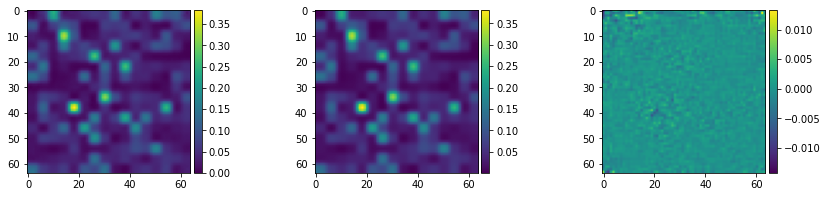

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


idx = np.random.choice(x_train.shape[0])

pred = unet(x_train[idx:idx+1, :, :, :])

fig = plt.figure(figsize=(15,3))
plt.subplots_adjust(wspace=0.1)
ax = fig.add_subplot(131)
im = ax.imshow(pred[0, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(132)
im = ax.imshow(x_train[idx, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(133)
im = ax.imshow((x_train[idx, :, :] - pred[0, :, :]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)


In [63]:
x_train[idx, :, :].min()

0.0002029701859883668

In [4]:
import numpy as np
import os
test_data = np.load(os.getcwd() + '/data/inputs_500.npy')

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True